- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
- Javier Alejandro Mejía Alecio #20304
- Erick Raúl Alvarez Melgar #20900

# Proyecto - Presentación de resultados

Guatemala es conocido como el país de la eterna primavera, debido a su diversidad de flora y fauna, además de contar
con un clima conocido como templado, es decir no existen climas extremos a lo largo del año. Sin embargo, así como
es conocido por su belleza natural, también es fuertemente reconocible por la corrupción y los bajos índices de calidad
de vida, y uno de ellos es el de mortalidad, la cual expresa la frecuencia con la cual ocurren las defunciones en una
población dada, en el caso de Guatemala, para el año 2019 fue de 4.72% (Datosmacro, 2021), es decir en promedio 5 muertes por cada 1000 habitantes.
A continuación se realizará un análisis exploratorio, sobre los datos de defunciones reportados por el Instituto Nacional de
Estadística de Guatemala -INE- de los años 2011 a 2020, y dentro de los cuales se pretende encontrar una situación problemática
la cual a su vez pueda ser resuelta con los datos analizados.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import optimizers

# Estilos
plt.style.use('ggplot')
#sns.set_theme(palette=None)

In [2]:
# Cargar los datos
deaths = pd.read_csv('final.csv')
# Como ya se cuenta con la causa de muerte (categorizada) la descripción sale sobrando
# De igual forma, el periodo de edad se puede obtener mediante la edad así que es info redundante
deaths = deaths.loc[:, deaths.columns != 'Perdif']
deaths = deaths.loc[:, deaths.columns != 'caudef.descrip']

C:\Users\Zaray\AppData\Local\Temp\ipykernel_1104\1461672132.py:2: DtypeWarning: Columns (7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  deaths = pd.read_csv('final.csv')


In [3]:
deaths['cause'] = deaths['Caudef'].copy()
repl = {r'([AB])(\d+.*)' : r'AB',
        r'(C)(\d+.*)' : r'CD',
        r'(D[0-4])(\d+.*)' : r'CD',
        r'(D[5-8])(\d+.*)' : r'DD',
        r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF',
        r'(G)(\d+.*)' : r'GG',
        r'(H[0-5])(\d+.*)' : r'HA',
        r'(H[6-9])(\d+.*)' : r'HB',
        r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ',
        r'(K)(\d+.*)' : r'KK',
        r'(L)(\d+.*)' : r'LL',
        r'(M)(\d+.*)' : r'MM',
        r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO',
        r'(P)(\d+.*)' : r'PP',
        r'(Q)(\d+.*)' : r'QQ',
        r'(R)(\d+.*)' : r'RR',
        r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY',
        r'([Z])(\d+.*)' : r'ZZ',
        r'([U])(\d+.*)' : r'UU',
        }
deaths.cause = deaths['cause'].replace(repl, regex=True)
deaths['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

In [4]:
# Eliminación de toda la información pertinente al difunto en sí, porque no se pretende trabajar con los difuntos en sí
sample = deaths.drop(['Areag', 'Depreg', 'Mupreg', 'Mesreg', 'Añoreg','Mupocu','Edadif','Puedif','Ecidif','Escodif','Ciuodif','Pnadif','Dnadif','Mnadif', 'Nacdif', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Caudef'], axis=1)

In [5]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
sample = sample.groupby(by=['cause','Depocu', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur', 'Cerdef']).count()
sample.columns = ['number_deaths']

In [6]:
# Nuevo conjunto de datos
sample = sample.reset_index(level=['cause', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur','Cerdef','Depocu'])

<AxesSubplot:xlabel='number_deaths', ylabel='Count'>

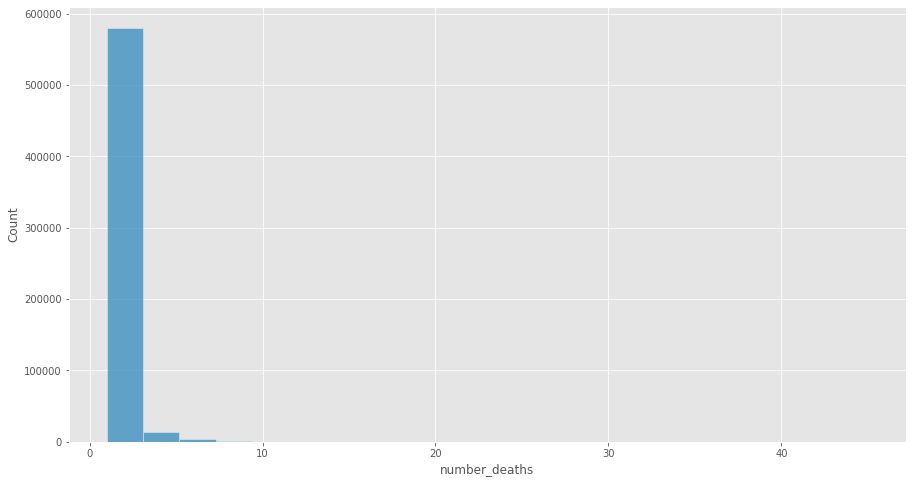

In [7]:
# Visualización gráfica de la distribución de la variable objetivo
plt.figure(figsize=(15, 8))
sns.histplot(sample.number_deaths)

In [ ]:
# Evaluar la correlación de las variables para ver cuáles se pueden eliminar
for column in sample.columns:
  if column != 'cause':
    crosstable = pd.crosstab(sample[column], sample['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

In [8]:
# Eliminando las variables asociadas
sample = sample.drop(['Asist', 'Diaocu', 'Cerdef'], axis=1)

In [9]:
# Agrupando nuevamente y regresando al índice numérico
sample = sample.groupby(['cause', 'Ocur','Depocu', 'Añoocu', 'Mesocu']).count()
sample = sample.reset_index(level=['cause', 'Ocur','Depocu', 'Añoocu', 'Mesocu'])

0        1
1        1
2        1
3        1
4        1
        ..
93232    3
93233    3
93234    2
93235    3
93236    3
Name: number_deaths, Length: 93237, dtype: int64

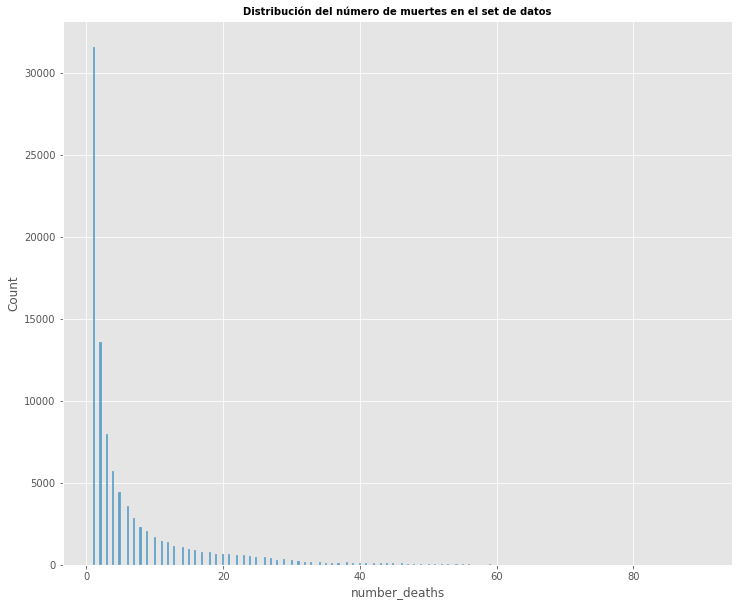

In [25]:
plt.figure(figsize=(12, 10))
sns.histplot(sample.number_deaths)
plt.title('Distribución del número de muertes en el set de datos', fontsize = 10, fontweight = "bold")

sample.number_deaths

In [11]:
# Codificación de las variables
encoder = OrdinalEncoder(dtype=int)
for column in sample.columns:
        if column != 'number_deaths':
                sample[column] = encoder.fit_transform(sample[[column]])
                print(encoder.categories_)

[array(['AB', 'CD', 'DD', 'EE', 'FF', 'GG', 'HA', 'HB', 'II', 'JJ', 'KK',
       'LL', 'MM', 'NN', 'OO', 'PP', 'QQ', 'RR', 'UU', 'VY'], dtype=object)]
[array(['Centro de salud', 'Domicilio', 'Hospital privado',
       'Hospital público', 'Ignorado', 'Lugar de trabajo', 'Otro',
       'Seguro social', 'Vía pública'], dtype=object)]
[array(['Alta Verapaz', 'Baja Verapaz', 'Chimaltenango', 'Chiquimula',
       'El Progreso', 'Escuintla', 'Guatemala', 'Huehuetenango', 'Izabal',
       'Jalapa', 'Jutiapa', 'Peten', 'Petén', 'Quetzaltenango', 'Quiche',
       'Quiché', 'Retalhuleu', 'Sacatepequez', 'Sacatepéquez',
       'San Marcos', 'Santa Rosa', 'Solola', 'Sololá', 'Suchitepequez',
       'Totonicapan', 'Totonicapán', 'Zacapa'], dtype=object)]
[array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)]
[array(['Abril', 'Agosto', 'Diciembre', 'Enero', 'Febrero', 'Julio',
       'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'],
      dtype=object)

In [12]:
# Variables para predecir
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
# Conjuntos de entrenamiento y prueba
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.33,
                                                                                stratify=predictors['cause'], random_state=190243)

# Árbol de decisión

In [40]:
# Creando y entrenando el modelo
regression_model = DecisionTreeRegressor(max_depth=12, random_state=42)
regression_model = regression_model.fit(X=predictors_train, y=target_train)

Variance Score: 0.8659963627950467
Mean absolute Error: 1.9246124404313678
Mean squared error: 10.542819065086885


,Predicted,Real
75006,13.871212,14
75967,1.000000,1
58974,1.000000,2
85781,6.807692,7
69973,1.500000,2
45587,1.000000,1
76835,1.336364,1
62481,2.428571,2
71871,2.084444,2
24085,3.327586,3


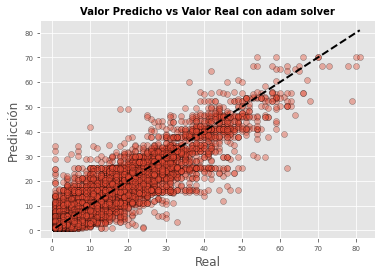

In [41]:
# Evaluando el modelo
prediction = regression_model.predict(predictors_test)
results = pd.DataFrame({
    'Predicted': prediction,
    'Real': target_test
})

print ("Variance Score:",explained_variance_score(target_test, prediction))
print ("Mean absolute Error:", mean_absolute_error(target_test, prediction))
print ("Mean squared error:", mean_squared_error(target_test, prediction))

# Comparación entre valores predichos y valores reales
plt.scatter(target_test, prediction, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.title('Valor Predicho vs Valor Real con adam solver', fontsize = 10, fontweight = "bold")
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.tick_params(labelsize = 7)

results.tail(10)

In [17]:
# Cálculo de los residuos
residuos  = prediction - target_test

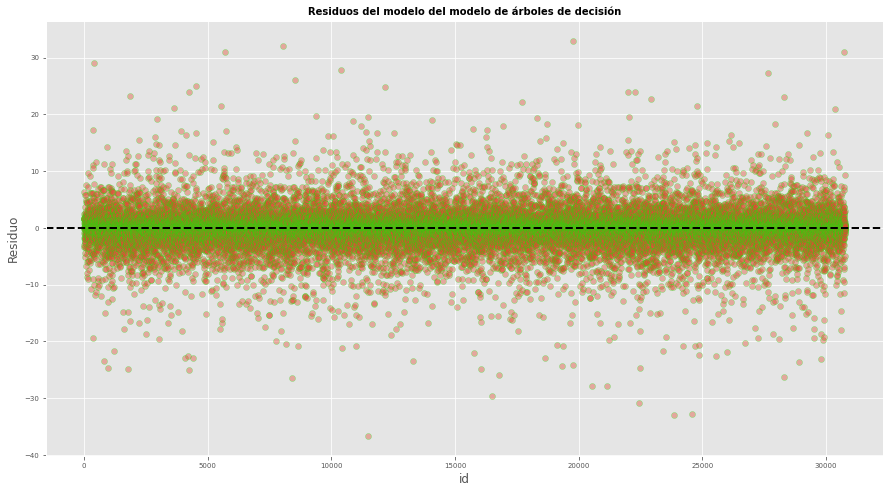

In [18]:
# Evaluando la eficiencia del modelo
plt.figure(figsize=(15, 8))

# Residuos Modelo 1
plt.scatter(list(range(len(prediction))), residuos,edgecolors=(0, 1, 0), alpha = 0.4)
plt.axhline(y = 0, linestyle = '--', color = 'black', lw=2)
plt.title('Residuos del modelo del modelo de árboles de decisión', fontsize = 10, fontweight = "bold")
plt.xlabel('id')
plt.ylabel('Residuo')
plt.tick_params(labelsize = 7)

plt.savefig('decision_tree.png')
plt.show()

# Redes neuronales

In [ ]:
# Finding the shape of the data
print('Train')
print('Predictors: ', predictors_train.shape, 'Target:', target_train.shape)
print('Test')
print('Predictors: ', predictors_test.shape, 'Target:', target_test.shape)

sample_shape = predictors_train.shape[1:]
print('Data shape:', sample_shape)

In [ ]:
# Creación del modelo de red neuronal
# Capas de la red
def create_network():
    input = Input(shape=sample_shape, name='input')
    process = Dense(32, activation='relu', name='dense1')(input)
    process = Dense(64, activation='relu', name='dense2')(process)
    process = Dense(16, activation='relu', name='dense3')(process)
    dropout = Dropout(0.15, name='dropout')(process)
    process = Dense(8, activation='relu', name='dense4')(process)
    process = Dense(1, activation=None, name='regressor')(process)
    # Creación del modelo
    nn_model = Model(input, process, name='Number_deaths')

    # Compilando el modelo
    optimizer = optimizers.Adam(learning_rate=1e-3, decay=1e-4)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return nn_model

In [ ]:
nn_model = create_network()
# Entrenamiento de las redes
history = nn_model.fit(predictors_train, target_train, epochs=20, batch_size=153, validation_split=0.15)

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['mae']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_mae']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'mean squared error', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# Haciendo predicciones con redes neuronales
prediction = nn_model.predict(predictors_test)
prediction = np.squeeze(prediction)

In [ ]:
results = pd.DataFrame({
    'Predicted': prediction,
    'Real': target_test
})

print ("Variance Score:",explained_variance_score(target_test, prediction))
print ("Mean absolute Error:", mean_absolute_error(target_test, prediction))
print ("Mean squared error:", mean_squared_error(target_test, prediction))

results.tail(10)

# Comparación entre valores predichos y valores reales
plt.scatter(target_test, prediction, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.title('Gráfico 5. Valor Predicho vs Valor Real con adam solver', fontsize = 10, fontweight = "bold")
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.tick_params(labelsize = 7)

### Random Forest Regresión

#### Multicolinealidad de las variables

In [42]:
vif_data = pd.DataFrame() 
G = sample
vif_data["feature"] = G.columns

vif_data["VIF"] = [variance_inflation_factor(G.values, i) for i in range(len(G.columns))]

print(vif_data)

         feature       VIF
0          cause  3.111520
1           Ocur  2.664719
2         Depocu  2.635346
3         Añoocu  2.854654
4         Mesocu  2.868334
5  number_deaths  1.441772


De acuerdo con el análisis de multicolinealidad se debe hacer un drop del año de ocurrencia

In [44]:
# Eliminando las variables asociadas
sample = sample.drop(['Añoocu'], axis=1)

In [45]:
# Agrupando nuevamente y regresando al índice numérico
sample = sample.groupby(['cause', 'Ocur','Depocu','Mesocu']).count()
sample = sample.reset_index(level=['cause', 'Ocur','Depocu','Mesocu'])

In [46]:
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']

In [47]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.33, stratify=predictors['cause'])
print(predictors_train)

       cause  Ocur  Depocu  Mesocu
1618       1     1      26       6
118        0     1       5       1
14379     14     2      14       9
5114       4     1       3       7
8439       8     6      12       1
...      ...   ...     ...     ...
5910       5     1       2       0
553        0     2      20       7
4103       3     2      18       5
4224       3     3       4       1
16517     16     3      10       0

[14183 rows x 4 columns]


In [48]:
CT = RandomForestRegressor(n_estimators=50, max_depth=15, random_state = 1000)
CT.fit(predictors_train,target_train)

RandomForestRegressor(max_depth=15, n_estimators=50, random_state=1000)

In [49]:
Y_pred = CT.predict(predictors_test)
YT_pred = CT.predict(predictors_train)

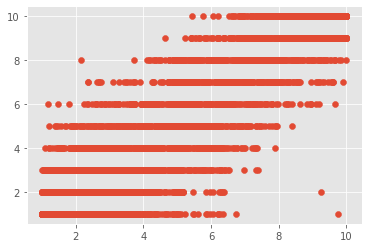

In [50]:
plt.scatter(Y_pred, target_test)

In [51]:
print("R squared: %.2f"%r2_score(target_test,Y_pred))
print("R squared teórico: %.2f"%r2_score(target_train,YT_pred))

R squared: 0.88
R squared teórico: 0.94


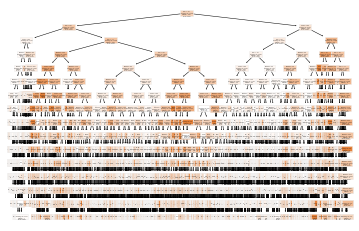

In [52]:
plt.figure()
_ = tree.plot_tree(CT.estimators_[0], feature_names=G.columns, filled=True)

#### Residuos

In [53]:
residuales = Y_pred - target_test

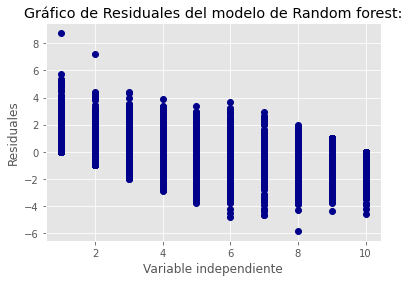

In [54]:
plt.plot(target_test,residuales, 'o', color='darkblue')
plt.title("Gráfico de Residuales del modelo de Random forest:")
plt.xlabel("Variable independiente")
plt.ylabel("Residuales")
plt.show()
# %%


C:\Users\Zaray\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


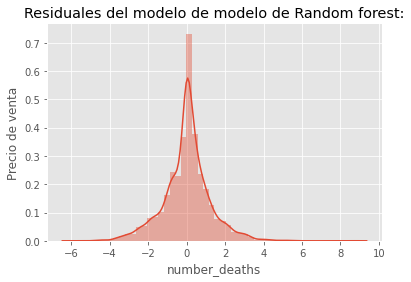

In [55]:
sns.distplot(residuales);
plt.title("Residuales del modelo de modelo de Random forest:")
plt.ylabel("Precio de venta")
plt.show()

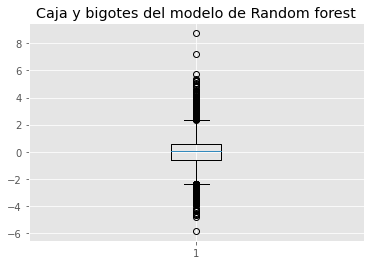

In [56]:
plt.boxplot(residuales)
plt.title('Caja y bigotes del modelo de Random forest')
plt.show()


